In [184]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [559]:
def wrangle(filepath):
    # Read csv
    df = pd.read_csv(filepath)#, index_col='country')
    shape_before = df.shape
    columns_before = df.columns
    
    # Rename columns (Delete "Value" from numerical column names)
    df.columns = df.columns.str.replace('Value', '', regex=False).str.strip()
    # Fix the corrupted values
    df["Property Price to Income"] = df["Property Price to Income"].str.replace(r"[^\d.]", "", regex=True).astype(float)
    df["Quality of Life"] = df["Quality of Life"].str.replace(r"[^\d.]", "", regex=True).astype(float)
    
    #Change the negative climate value associated with Mongolia for a positive one
    df.loc["Mongolia","Climate"] = 3.54
    
    # Remove parentheses from categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col]=df[col].str.replace("'", "").str.strip()

    # Replace 'zeros' with NaNs
    #df.replace(0.00, np.nan, inplace=True)
    # Drop columns with empty values
    #df.dropna(axis=1, inplace=True)
    # Drop rows with empty values
    #df.dropna(inplace=True)
    # Print info
    print(f"Dataset contains {df.duplicated().sum()} duplicates, the df shape changed from {shape_before} to {df.shape}, \
    columns before were {columns_before}, \n\n now \n\n {df.columns}")
    return df
    
    


In [840]:
df = wrangle("Quality_of_Life.csv")

Dataset contains 0 duplicates, the df shape changed from (236, 19) to (237, 19),     columns before were Index(['country', 'Purchasing Power Value', 'Purchasing Power Category',
       'Safety Value', 'Safety Category', 'Health Care Value',
       'Health Care Category', 'Climate Value', 'Climate Category',
       'Cost of Living Value', 'Cost of Living Category',
       'Property Price to Income Value', 'Property Price to Income Category',
       'Traffic Commute Time Value', 'Traffic Commute Time Category',
       'Pollution Value', 'Pollution Category', 'Quality of Life Value',
       'Quality of Life Category'],
      dtype='object'), 

 now 

 Index(['country', 'Purchasing Power', 'Purchasing Power Category', 'Safety',
       'Safety Category', 'Health Care', 'Health Care Category', 'Climate',
       'Climate Category', 'Cost of Living', 'Cost of Living Category',
       'Property Price to Income', 'Property Price to Income Category',
       'Traffic Commute Time', 'Traffic Commut

In [332]:
from bs4 import BeautifulSoup
import requests
import re
import ast

In [334]:
url = 'https://www.numbeo.com/quality-of-life/rankings_by_country.jsp?title=2023&displayColumn=8'
page = requests.get(url)
soup = BeautifulSoup(page.text, 'html')

In [335]:
string=soup.find('script',string = re.compile(r"data.addRows\(\[")).text.strip()
#print(soup.prettify())
# Define a regex pattern that finds the content between data.addRows([ and ]);
pattern = r"data\.addRows\(\s*(\[[\s\S]*?\])\s*\);"

match = re.search(pattern, string)
if match:
    # Extract the group which contains the list of lists
    list_of_lists = match.group(1)
    #print(list_of_lists)
else:
    print("No matching data found!")

cleaned_string = re.sub(r'\s+', ' ', str(list_of_lists)).strip()
cleaned_string = cleaned_string[:-3] + "]"

data_list = ast.literal_eval(cleaned_string)
#print(data_list[12])


In [338]:
for country in df[df["Climate"]==0.00].index:
    for i in data_list:
        if country == i[0]:
            df.loc[country, "Climate"] = i[1]
            print(f"Filled in {country} climate value with {i[1]}")

In [842]:
df=df.dropna()

In [845]:
df.shape

(114, 19)

In [847]:
df["Property Price to Income"].sort_values().tail(10)
df.loc[[29,208,176,219]]

,country,Purchasing Power,Purchasing Power Category,Safety,Safety Category,Health Care,Health Care Category,Climate,Climate Category,Cost of Living,Cost of Living Category,Property Price to Income,Property Price to Income Category,Traffic Commute Time,Traffic Commute Time Category,Pollution,Pollution Category,Quality of Life,Quality of Life Category
29,Botswana,64.60,Moderate,47.30,Moderate,61.12,High,88.87,Very High,40.05,Low,118.01,Very High,28.53,Low,46.09,Moderate,36.55,Very Low
208,Tanzania,23.52,Very Low,46.46,Moderate,42.14,Moderate,71.28,High,25.31,Very Low,134.04,Very High,27.79,Low,62.48,High,0.00,Very Low
176,Rwanda,20.50,Very Low,72.81,High,72.87,High,99.74,Very High,37.05,Very Low,446.83,Very High,15.67,Very Low,39.22,Low,0.00,Very Low
219,Uganda,10.33,Very Low,45.88,Moderate,50.05,Moderate,98.41,Very High,47.97,Low,1075.92,Very High,44.50,High,84.05,Very High,0.00,Very Low


## Outliers
Impute outliers with the mean value of the Property Price to Income for the subset of countries where the corresponding category was labeled as Very High.
To keep the ordinal relationship between the countries, the mean is increased by an arbitrary number.
We see that for a subset excluding the two highest values, the mean is roughly 27.18 and the standard deviation is 20.57.
Thus it is reasonable to set a cutoff for outliers at the mean + 3*std, which is 88.89

We have only 4 values higher than that in the dataset, so to keep them in order and within set boundaries, we will set the highest value to 88.89,
the second highest value to 88.89 - 1, and so on.


In [850]:
df["Property Price to Income"][df["Property Price to Income"]<130].loc[df["Property Price to Income Category"] == "Very High"].describe()

count     33.000000
mean      27.177879
std       20.573309
min       16.000000
25%       17.850000
50%       20.890000
75%       25.590000
max      118.010000
Name: Property Price to Income, dtype: float64

In [852]:
df.loc[[29,208,176,219], "Property Price to Income"] = np.array([88.89, 88.89-1, 88.89-2, 88.89-3])

In [854]:
df.describe()

,Purchasing Power,Safety,Health Care,Climate,Cost of Living,Property Price to Income,Traffic Commute Time,Pollution,Quality of Life
count,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000,114.000000
mean,72.673421,57.905789,62.604298,77.834825,41.411053,17.013246,35.434649,56.154649,131.387368
std,42.417819,13.601773,10.202121,17.637645,15.366051,16.501797,9.407027,19.970989,46.616945
min,10.330000,25.360000,41.050000,-3.540000,17.900000,2.810000,15.670000,11.830000,0.000000
25%,40.285000,48.192500,55.245000,67.977500,29.930000,9.145000,28.662500,40.950000,104.462500
50%,57.920000,57.005000,62.110000,80.600000,37.925000,12.905000,35.175000,60.465000,129.720000
75%,107.965000,68.230000,71.072500,91.692500,49.422500,17.235000,40.375000,72.177500,164.945000
max,195.550000,84.430000,86.500000,99.890000,101.180000,88.890000,65.310000,89.410000,224.310000


Next up, there are some outliers with the Quality of Life index set at 0.
While the quality of life might be very low in these countries, it's very unlikely that 0 was the intended input.
We can assume a linear relationship between the quality of life and the other features, as the quality of life index is the outcome of a combination of the other, measurable, qualities. Thus we can try to predict it with a linear regression model.

In [857]:
df[df["Quality of Life"] == 0].select_dtypes(include="number")

,Purchasing Power,Safety,Health Care,Climate,Cost of Living,Property Price to Income,Traffic Commute Time,Pollution,Quality of Life
176,20.50,72.81,72.87,99.74,37.05,86.89,15.67,39.22,0.0
208,23.52,46.46,42.14,71.28,25.31,87.89,27.79,62.48,0.0
219,10.33,45.88,50.05,98.41,47.97,85.89,44.50,84.05,0.0


In [859]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


X = df.loc[df["Quality of Life"] != 0].select_dtypes(include="number").drop(columns="Quality of Life")
y = df.loc[df["Quality of Life"] != 0, ["Quality of Life"]]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, shuffle=False)

regressor = LinearRegression().fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, r2_score

y_pred = regressor.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 1.26
Coefficient of determination: 1.00


In [863]:
df.loc[df["Quality of Life"] == 0, "Quality of Life"] = regressor.predict(df.loc[df["Quality of Life"] == 0].select_dtypes(include="number").drop(columns="Quality of Life"))

In [877]:
df["Quality of Life"].sort_values()
df.loc[df["Quality of Life Category"] == 'Very Low', "Quality of Life"].describe()

count    26.000000
mean     72.950186
std      29.074696
min      -0.231315
25%      64.150056
50%      84.965000
75%      93.912500
max      99.980000
Name: Quality of Life, dtype: float64

In [913]:
value = df.loc[140, "Quality of Life"]

prediction = regressor.predict(df.select_dtypes(include='number').drop(columns="Quality of Life").loc[[140]])

print(f"The actual value is {value}, vs the prediction of {round(prediction[0][0],2)}")

The actual value is 147.33, vs the prediction of 145.99


<Axes: >

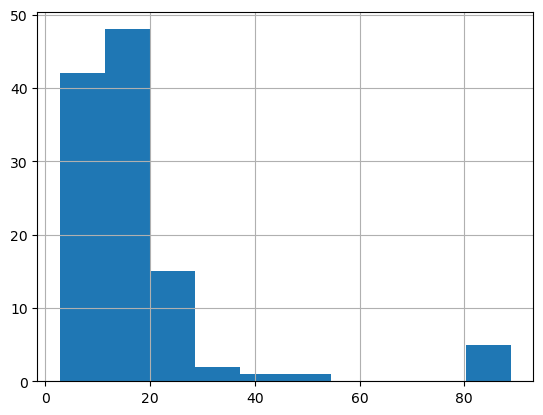

In [935]:
df["Climate"].sort_values()  # Mongolia isn't fixed for some reason
df["Property Price to Income"].hist()

In [925]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 2 to 235
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            114 non-null    object 
 1   Purchasing Power                   114 non-null    float64
 2   Purchasing Power Category          114 non-null    object 
 3   Safety                             114 non-null    float64
 4   Safety Category                    114 non-null    object 
 5   Health Care                        114 non-null    float64
 6   Health Care Category               114 non-null    object 
 7   Climate                            114 non-null    float64
 8   Climate Category                   114 non-null    object 
 9   Cost of Living                     114 non-null    float64
 10  Cost of Living Category            114 non-null    object 
 11  Property Price to Income           114 non-null    float64
 12 

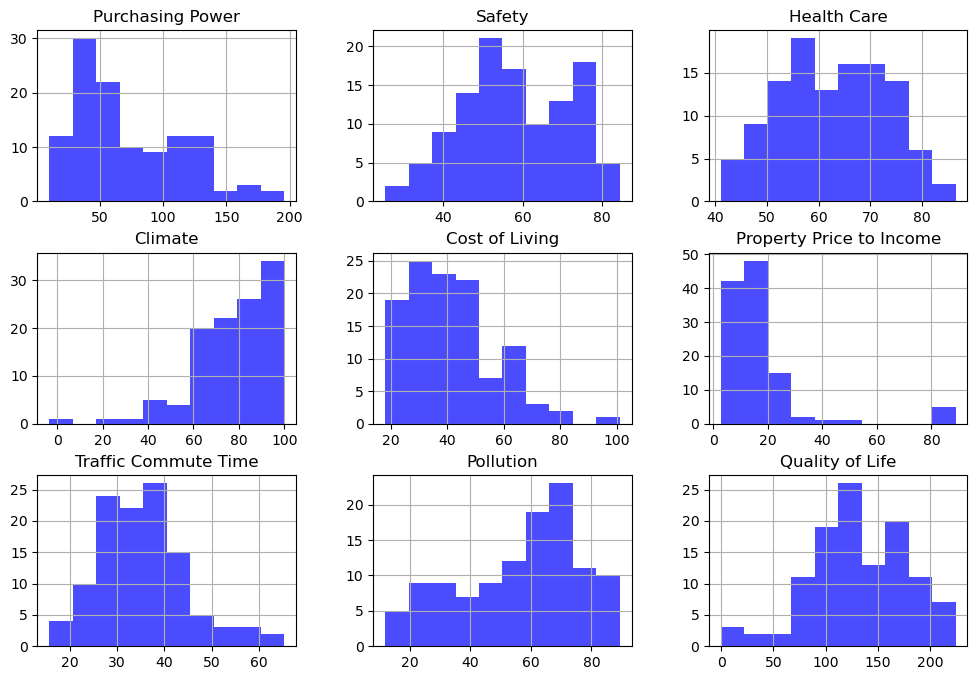

In [927]:
df.hist(figsize=(12,8), alpha=0.7, color="blue")
plt.show()

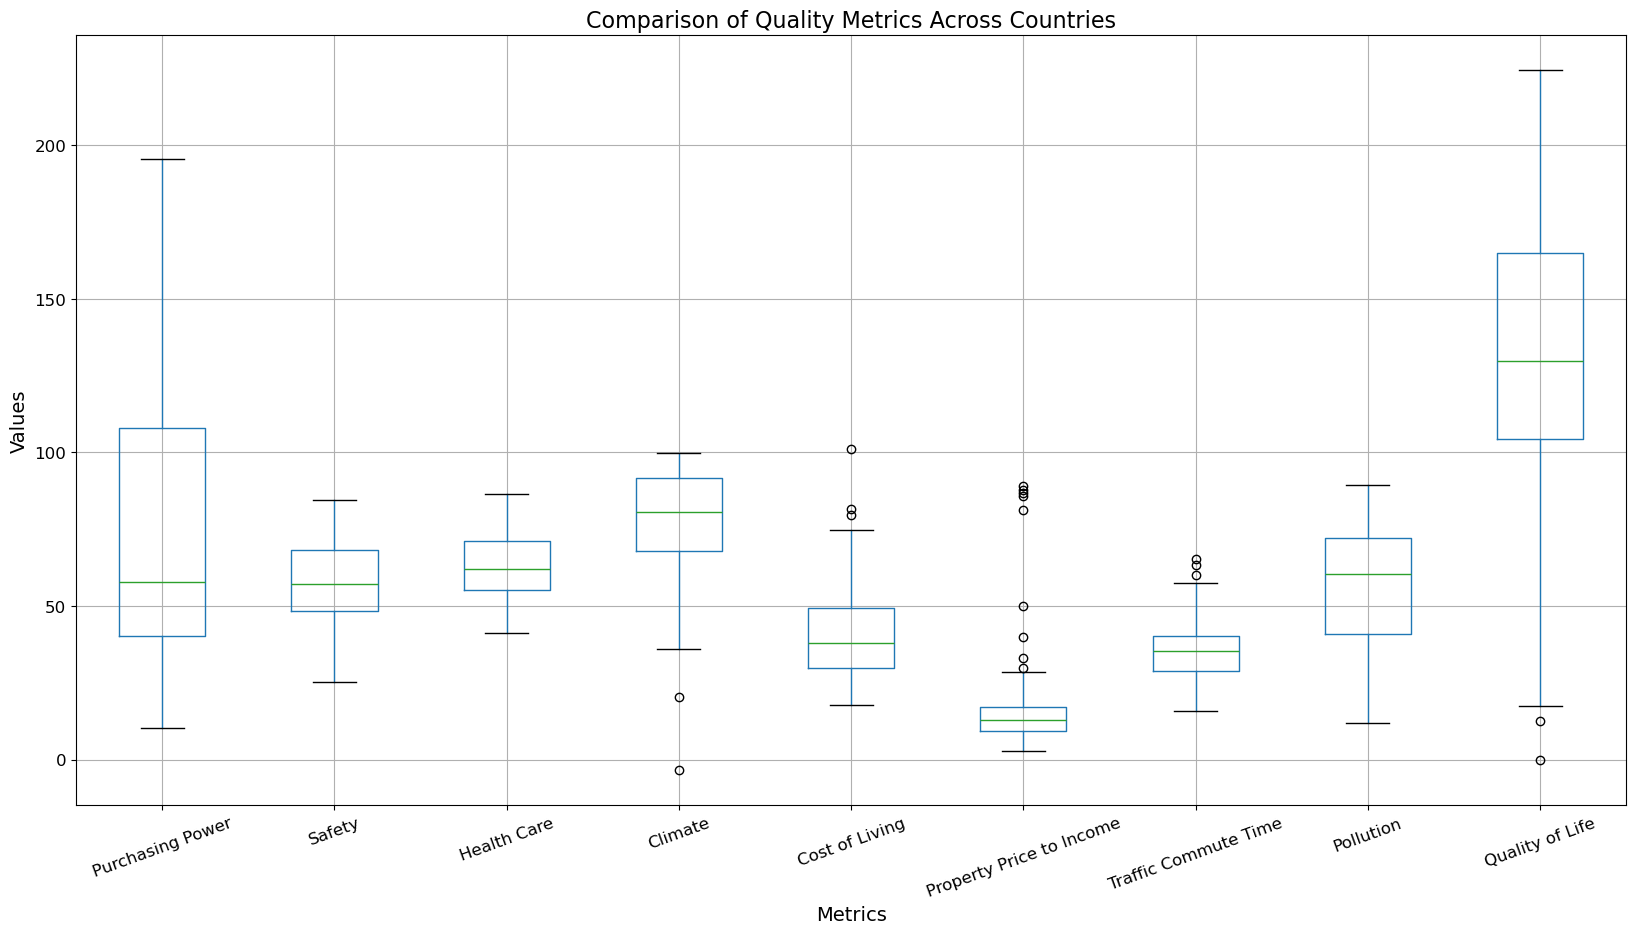

In [929]:
df.boxplot(figsize=(20,10))
# Customize the plot
plt.title("Comparison of Quality Metrics Across Countries", fontsize=16)
plt.ylabel("Values", fontsize=14)
plt.xlabel("Metrics", fontsize=14)
plt.xticks(rotation=20, fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
#plt.tight_layout()
plt.show()

In [353]:
df[['Climate']].sort_values(by='Climate')
#df[['Property Price to Income', 'country']].sort_values(by='Property Price to Income')
#df[['Cost of Living', 'country']].sort_values(by='Cost of Living')
#df[['Traffic Commute Time','country']].sort_values(by='Traffic Commute Time')

df.loc["Mongolia","Climate"] = 3.54
df.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'Violin Plots per Metric')

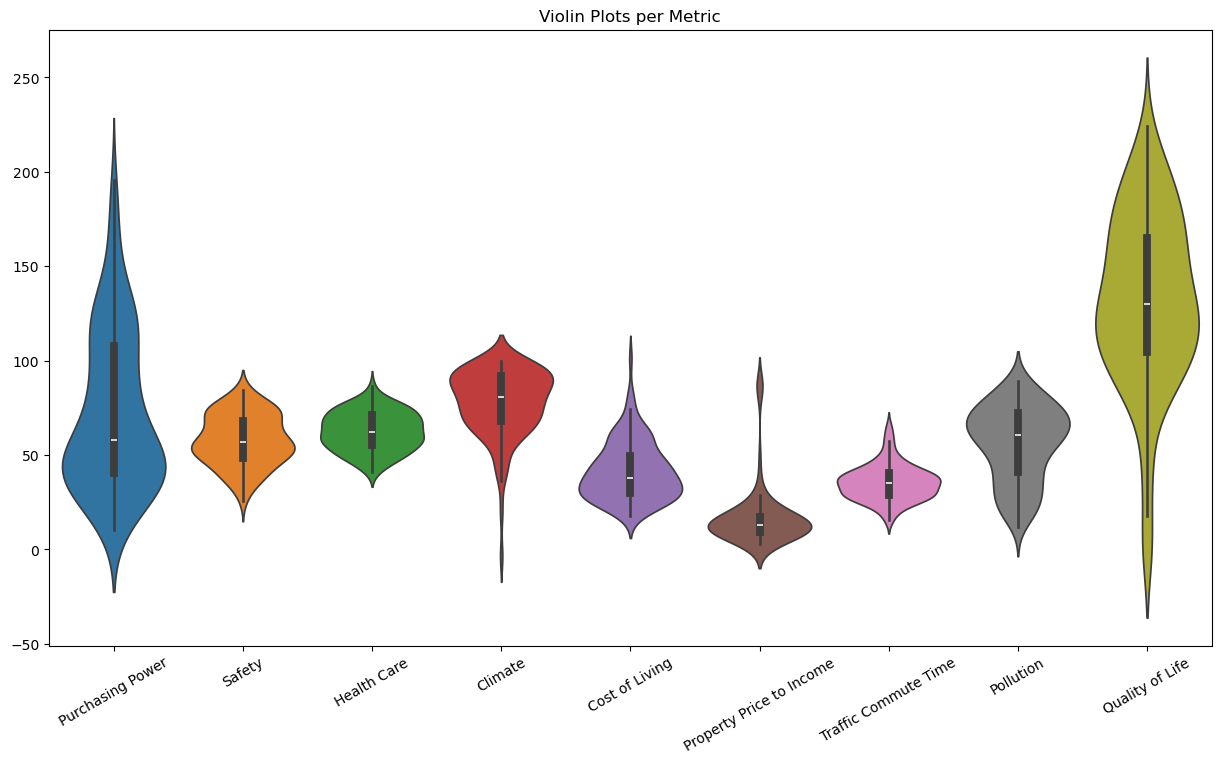

In [613]:
plt.figure(figsize=(15, 8))
sns.violinplot(data=df)
plt.xticks(rotation=30)
plt.title("Violin Plots per Metric")

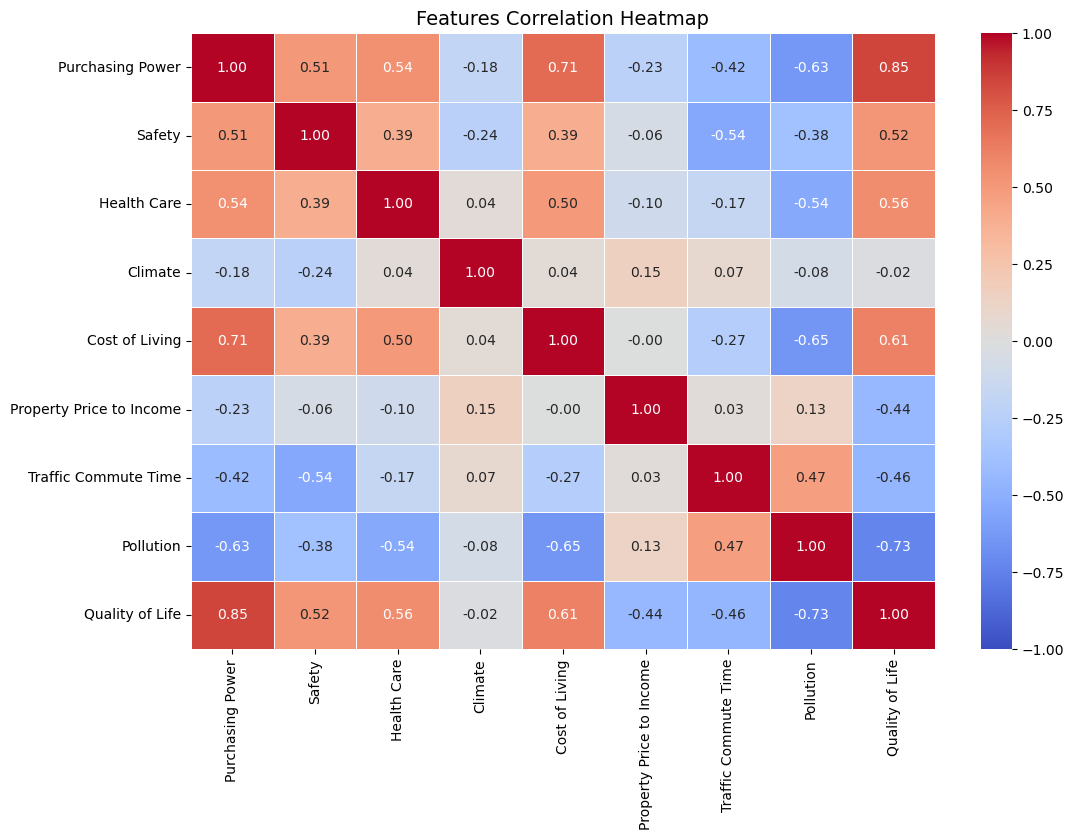

In [357]:
# Set up the figure size
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(df.select_dtypes(include="float").corr(), 
            annot=True,  # Display correlation values
            fmt=".2f",   # Format to 2 decimal places
            cmap="coolwarm",  # Color palette (red-blue)
            center=0,   # Center around zero
            linewidths=0.5,  # Add grid lines
            vmin=-1, vmax=1)  # Set correlation range

# Add a title
plt.title("Features Correlation Heatmap", fontsize=14)

# Show the plot
plt.show()

In [359]:
df['Cost of Living'].corr(df['Property Price to Income'])

-0.003184601181970011

In [361]:
df.head()

,country,Purchasing Power,Purchasing Power Category,Safety,Safety Category,Health Care,Health Care Category,Climate,Climate Category,Cost of Living,Cost of Living Category,Property Price to Income,Property Price to Income Category,Traffic Commute Time,Traffic Commute Time Category,Pollution,Pollution Category,Quality of Life,Quality of Life Category
0,Albania,42.82,'Low',55.52,'Moderate',48.21,'Moderate',86.43,'Very High',40.85,'Low',14.88,'High',36.74,'Moderate',77.25,'High',104.16,'Low'
1,Algeria,27.60,'Very Low',47.54,'Moderate',54.43,'Moderate',94.82,'Very High',25.31,'Very Low',21.70,'Very High',45.09,'High',63.87,'High',98.83,'Very Low'
2,Argentina,40.36,'Low',36.36,'Low',68.00,'High',98.28,'Very High',32.65,'Very Low',20.05,'Very High',44.07,'High',50.81,'Moderate',115.06,'Low'
3,Armenia,36.91,'Very Low',77.81,'High',58.07,'Moderate',63.42,'High',41.84,'Low',20.95,'Very High',29.31,'Low',62.55,'High',116.56,'Low'
4,Australia,137.58,'Very High',52.71,'Moderate',73.35,'High',93.80,'Very High',64.50,'Moderate',8.25,'Moderate',37.48,'Moderate',26.80,'Low',190.69,'Very High'


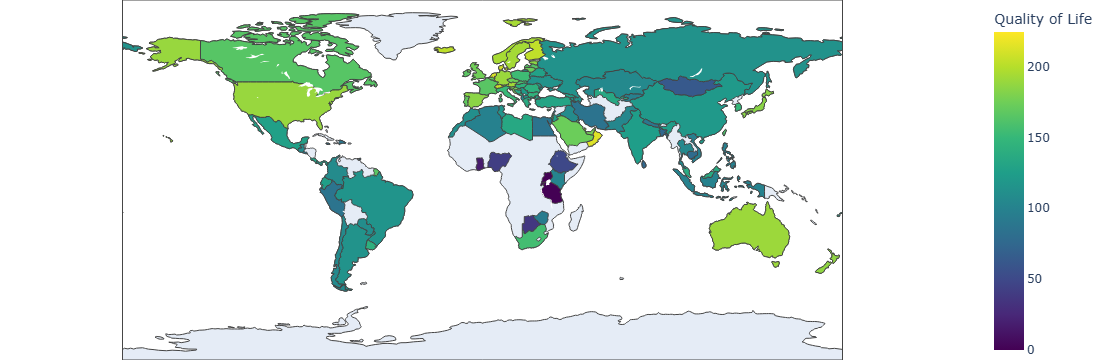

In [363]:
df.reset_index(drop=True,inplace=True)

# create figure
fig = px.choropleth(locations=df['country'].tolist(),
                    locationmode="country names", 
                    color=df['Quality of Life'].to_list(), 
                    scope="world", 
                    color_continuous_scale="Viridis",
                    labels={'color':'Quality of Life',
                           'locations':'Country'}
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

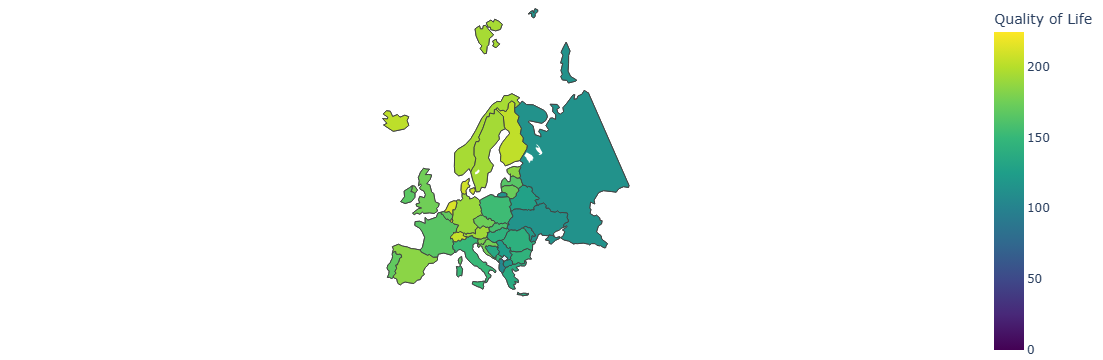

In [365]:
# create figure
fig = px.choropleth(locations=df['country'].tolist(),
                    locationmode="country names", 
                    color=df['Quality of Life'].to_list(), 
                    scope="europe", 
                    color_continuous_scale="Viridis",
                    labels={'color':'Quality of Life',
                           'locations':'Country'}
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

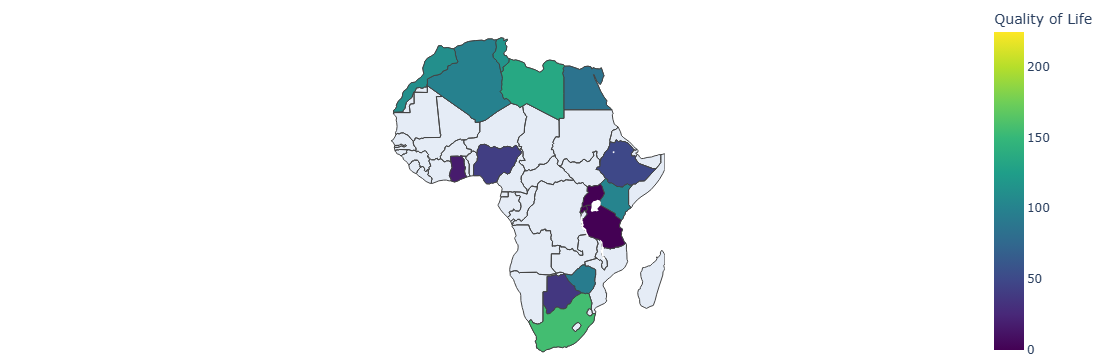

In [367]:
# create figure
fig = px.choropleth(locations=df['country'].tolist(),
                    locationmode="country names", 
                    color=df['Quality of Life'].to_list(), 
                    scope="africa", 
                    color_continuous_scale="Viridis",
                    labels={'color':'Quality of Life',
                           'locations':'Country'}
                    )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Text(0.5, 1.0, 'Top 10 Countries with the Highest Quality of Life')

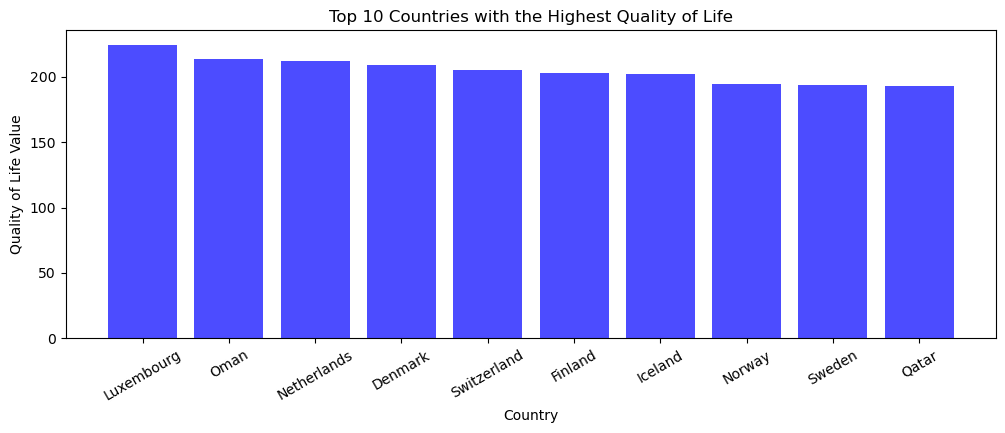

In [369]:
fig = plt.figure(figsize=(12,4))

top10 = df[['country', 'Quality of Life']].sort_values(by='Quality of Life', ascending=False).head(10)

fig=plt.bar(x=top10['country'], height=top10["Quality of Life"], color='blue', alpha=0.7)
plt.xticks(rotation=30)
plt.xlabel("Country")
plt.ylabel("Quality of Life Value")
plt.title("Top 10 Countries with the Highest Quality of Life")

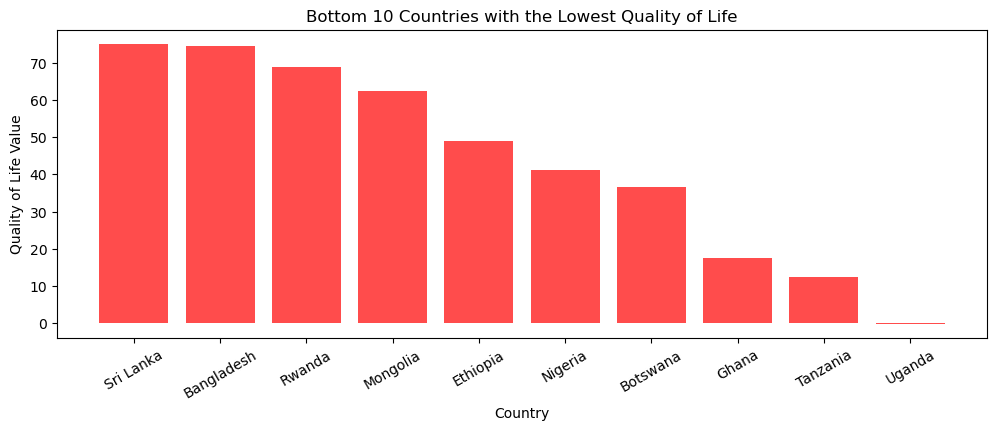

In [702]:

# Najpierw upewnij się, że usuwasz NaN-y w oryginalnym DataFrame
df['country'] = df['country'].replace(['', ' '], np.nan).dropna().astype(str)

# Wybierz bottom10 po oczyszczeniu
bottom10 = df[['country', 'Quality of Life']].sort_values(by='Quality of Life', ascending=False).tail(10)

# Rysujemy wykres
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(bottom10['country'], bottom10["Quality of Life"], color='red', alpha=0.7)

# Etykiety i tytuły
ax.set_xticks(range(len(bottom10['country'])))
ax.set_xticklabels(bottom10['country'], rotation=30)
ax.set_xlabel("Country")
ax.set_ylabel("Quality of Life Value")
ax.set_title("Bottom 10 Countries with the Lowest Quality of Life")

# Pokaż wykres
plt.show()


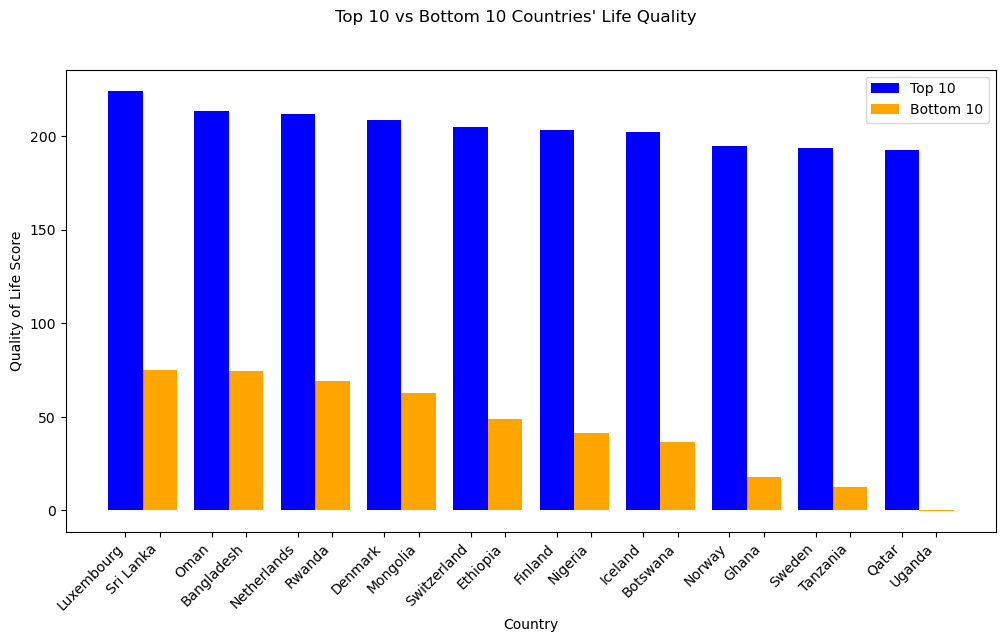

In [704]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

# Define bar width and positions
bar_width = 0.4
x_top = np.arange(len(top10))
x_bottom = np.arange(len(bottom10)) + bar_width  # Shifted for grouping

# Create grouped bar plot
ax.bar(x_top, top10["Quality of Life"], width=bar_width, label="Top 10", color="blue")  
ax.bar(x_bottom, bottom10["Quality of Life"], width=bar_width, label="Bottom 10", color="orange")

# Set x-axis labels
ax.set_xticks(np.concatenate([x_top, x_bottom]))  # Combine positions
ax.set_xticklabels(list(top10["country"]) + list(bottom10["country"]), rotation=45, ha="right")

# Add labels and legend
ax.set_xlabel("Country")
ax.set_ylabel("Quality of Life Score")
ax.legend()
fig.suptitle("Top 10 vs Bottom 10 Countries' Life Quality")
plt.show()


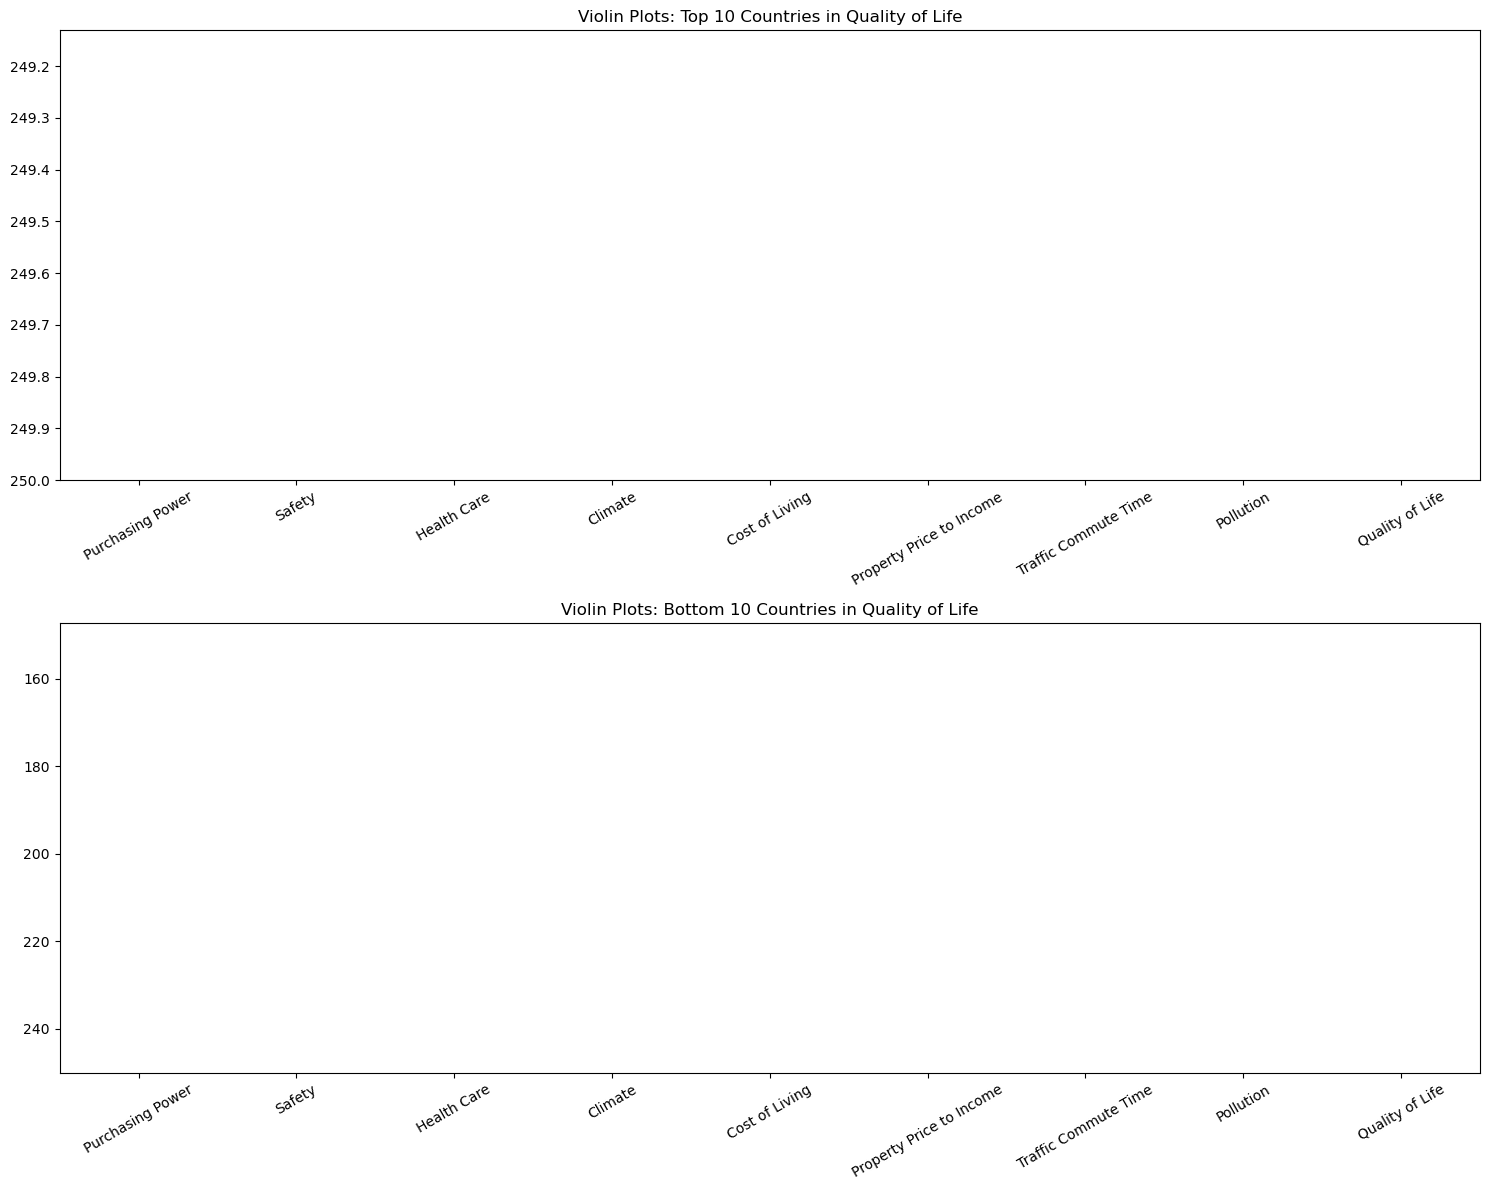

In [706]:

# Create a figure with two subplots arranged vertically
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

# Plot the top 10 countries on the first subplot (ax1)
sns.violinplot(data=df.sort_values(by='Quality of Life', ascending=False).head(10), ax=ax1)
ax1.set_title("Violin Plots: Top 10 Countries in Quality of Life")
ax1.tick_params(axis='x', rotation=30)  # Rotate x-axis labels for ax1

# Plot the bottom 10 countries on the second subplot (ax2)
sns.violinplot(data=df.sort_values(by='Quality of Life', ascending=False).tail(10), ax=ax2)
ax2.set_title("Violin Plots: Bottom 10 Countries in Quality of Life")
ax2.tick_params(axis='x', rotation=30)  # Rotate x-axis labels for ax2

# Set the same y-axis limits for both subplots
y_min = min(df['Quality of Life'].min(), df['Quality of Life'].min())  # Find the overall minimum value
y_max = max(df['Quality of Life'].max(), df['Quality of Life'].max())  # Find the overall maximum value
ax1.set_ylim(250)  # Apply the same limits to ax1
ax2.set_ylim(250)  # Apply the same limits to ax2

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_5268\4282080131.py:78: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



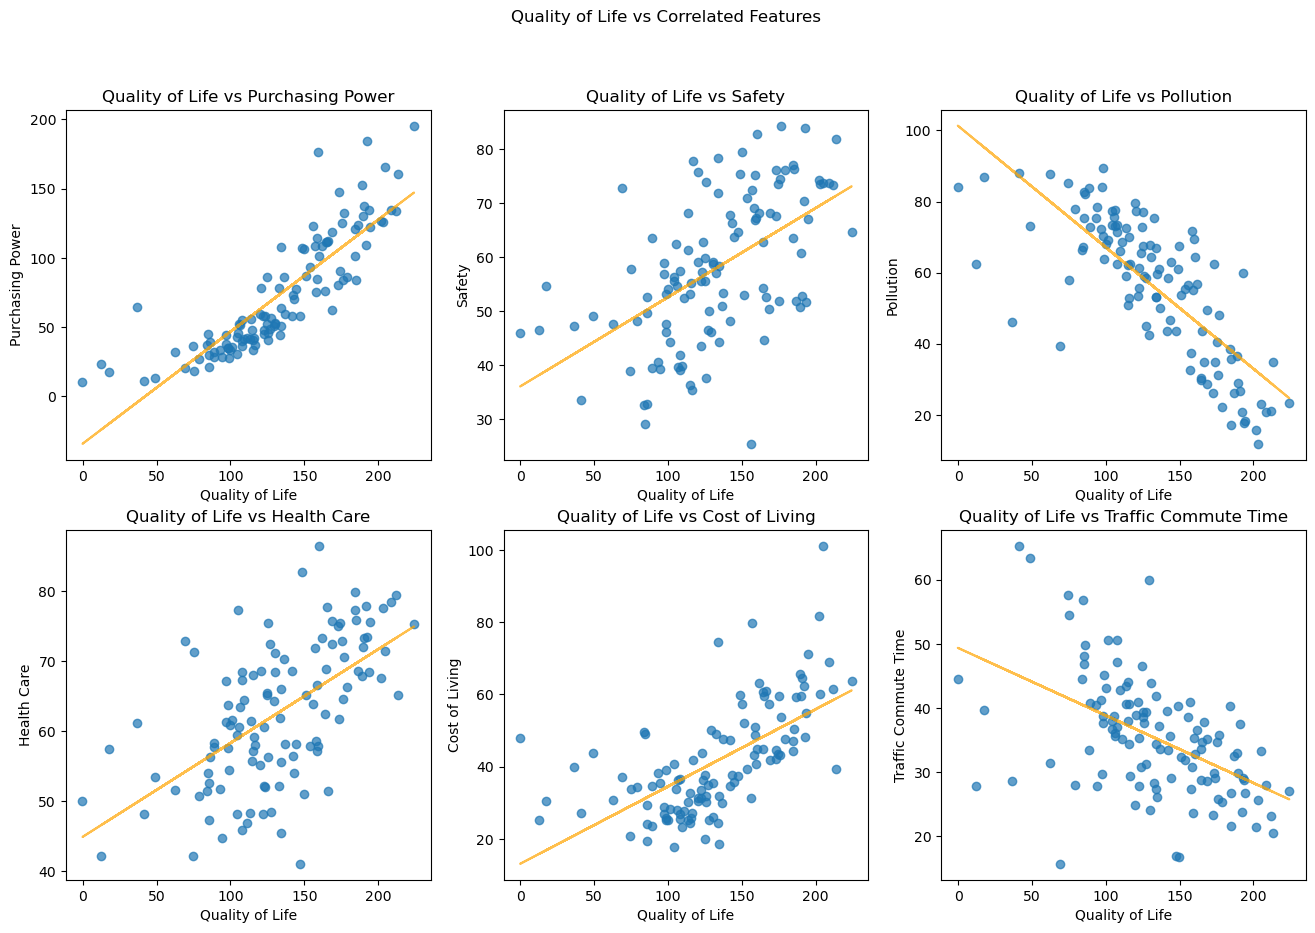

In [708]:
fig = plt.figure(figsize=(16,10))
fig.suptitle("Quality of Life vs Correlated Features")

ax1= fig.add_subplot(231)
ax1.scatter(x=df["Quality of Life"], y=df["Purchasing Power"], alpha=0.7)
ax1.set_title("Quality of Life vs Purchasing Power")
ax1.set_ylabel("Purchasing Power")
ax1.set_xlabel("Quality of Life")

ax2 = fig.add_subplot(232)
ax2.scatter(x=df["Quality of Life"], y=df["Safety"], alpha=0.7)
ax2.set_title("Quality of Life vs Safety")
ax2.set_ylabel("Safety")
ax2.set_xlabel("Quality of Life")

ax3 = fig.add_subplot(233)
ax3.scatter(x=df["Quality of Life"], y=df["Pollution"], alpha=0.7)
ax3.set_title("Quality of Life vs Pollution")
ax3.set_ylabel("Pollution")
ax3.set_xlabel("Quality of Life")

ax4 = fig.add_subplot(234)
ax4.scatter(x=df["Quality of Life"], y=df["Health Care"], alpha=0.7)
ax4.set_title("Quality of Life vs Health Care")
ax4.set_ylabel("Health Care")
ax4.set_xlabel("Quality of Life")

ax5 = fig.add_subplot(235)
ax5.scatter(x=df["Quality of Life"], y=df["Cost of Living"], alpha=0.7)
ax5.set_title("Quality of Life vs Cost of Living")
ax5.set_ylabel("Cost of Living")
ax5.set_xlabel("Quality of Life")

ax6 = fig.add_subplot(236)
ax6.scatter(x=df["Quality of Life"], y=df["Traffic Commute Time"], alpha=0.7)
ax6.set_title("Quality of Life vs Traffic Commute Time")
ax6.set_ylabel("Traffic Commute Time")
ax6.set_xlabel("Quality of Life")

################ PLOT TREND LINES ###################

# Extract the x and y values
x = df["Quality of Life"]
y = df["Purchasing Power"]

# Perform a linear regression (Ordinary Least Squares)
slope, intercept = np.polyfit(x, y, 1)  # Degree 1 for linear fit
trend_line = slope * x + intercept  # Compute the line values
ax1.plot(x, trend_line, color='orange', alpha=0.7, label="Trend Line")

y = df["Safety"]
slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept
ax2.plot(x, trend_line, color='orange', alpha=0.7, label="Trend Line")

y = df["Pollution"]
slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept
ax3.plot(x, trend_line, color="orange", alpha=0.7, label="Trend Line")

y = df["Health Care"]
slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept
ax4.plot(x, trend_line, color="orange", alpha=0.7, label="Trend Line")

y = df["Cost of Living"]
slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept
ax5.plot(x, trend_line, color="orange", alpha=0.7, label="Trend Line")

y = df["Traffic Commute Time"]
slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept
ax6.plot(x, trend_line, color="orange", alpha=0.7, label="Trend Line")

####################################################

fig.show()